
## Questão 1 - Modelo de Classificação para Análise de Fake News

Este script implementa a solução para a primeira questão da atividade prática
de Processamento de Linguagem Natural (NLP).

Desenvolvimento de modelo de classificação supervisionado para análise de Fake News
usando o corpus FakeBr.

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\phili\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


Iniciando processamento do modelo de classificação de fake news...
Carregando textos do corpus...
Total de textos: 7200
Textos verdadeiros: 3600
Textos falsos: 3600

Distribuição dos rótulos:
rotulo
REAL    3600
FAKE    3600
Name: count, dtype: int64
Realizando pré-processamento dos textos...
Criando vetores TF-IDF com n-gramas...
Número total de features (unigramas, bigramas e trigramas): 74651
Número de unigramas: 11386
Número de bigramas: 52932
Número de trigramas: 10333

Treinando modelos de classificação...

Treinando modelo: Naive Bayes
Acurácia: 0.7215
Relatório de classificação:
              precision    recall  f1-score   support

        FAKE       0.99      0.45      0.62       720
        REAL       0.64      1.00      0.78       720

    accuracy                           0.72      1440
   macro avg       0.82      0.72      0.70      1440
weighted avg       0.82      0.72      0.70      1440

Matriz de confusão:
[[321 399]
 [  2 718]]

Treinando modelo: SVM
Acurácia: 0.9

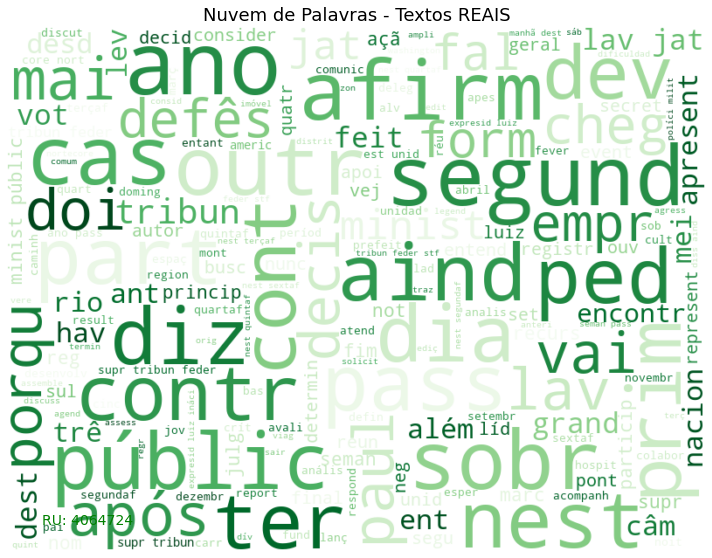


Resposta à pergunta da Questão 1:
--------------------------------------------------
Quantas palavras, bigramas e trigramas foram usados dos textos rotulados como REAL para a criação do modelo e qual a acurácia?
Total de termos usados dos textos REAL: 200
  - Unigramas: 178
  - Bigramas: 19
  - Trigramas: 3
Acurácia do melhor modelo (SVM): 96.60%


In [1]:
"""
Questão 1 - Modelo de Classificação para Análise de Fake News

Este script implementa a solução para a primeira questão da atividade prática
de Processamento de Linguagem Natural (NLP).

Desenvolvimento de modelo de classificação supervisionado para análise de Fake News
usando o corpus FakeBr.
"""

# Importando as bibliotecas necessárias
import os
import re
import nltk
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

# Bibliotecas NLTK
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
import string

# Bibliotecas scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Baixando recursos do NLTK necessários
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

def main():
    print("Iniciando processamento do modelo de classificação de fake news...")
    
    # Definir caminho para os diretórios
    base_dir = 'Fake.br-Corpus'
    true_dir = os.path.join(base_dir, 'full_texts', 'true')
    fake_dir = os.path.join(base_dir, 'full_texts', 'fake')
    
    # Verificar se os diretórios existem
    if not os.path.exists(true_dir) or not os.path.exists(fake_dir):
        print(f"Erro: Diretórios do corpus não encontrados. Verifique se o diretório {base_dir} existe.")
        return
    
    # Função para ler todos os arquivos em um diretório
    def ler_arquivos(diretorio):
        textos = []
        arquivos = sorted(glob(os.path.join(diretorio, '*.txt')))
        for arquivo in arquivos:
            with open(arquivo, 'r', encoding='utf-8') as f:
                textos.append(f.read())
        return textos
    
    # Ler os textos verdadeiros e falsos
    print("Carregando textos do corpus...")
    textos_true = ler_arquivos(true_dir)
    textos_fake = ler_arquivos(fake_dir)
    
    # Criar um DataFrame com os textos e rótulos
    df_true = pd.DataFrame({'texto': textos_true, 'rotulo': 'REAL'})
    df_fake = pd.DataFrame({'texto': textos_fake, 'rotulo': 'FAKE'})
    
    # Concatenar os dataframes
    df = pd.concat([df_true, df_fake], ignore_index=True)
    
    # Embaralhar o DataFrame
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Visualizar algumas estatísticas
    print(f"Total de textos: {len(df)}")
    print(f"Textos verdadeiros: {len(df_true)}")
    print(f"Textos falsos: {len(df_fake)}")
    print("\nDistribuição dos rótulos:")
    print(df['rotulo'].value_counts())
    
    # Definir stopwords em português
    stop_words = set(stopwords.words('portuguese'))
    
    # Adicionar pontuação às stopwords
    stop_words.update(set(string.punctuation))
    
    # Inicializar o stemmer
    stemmer = RSLPStemmer()
    
    def preprocessar_texto(texto):
        # Converter para minúsculas
        texto = texto.lower()
        
        # Remover caracteres especiais, URLs e números
        texto = re.sub(r'https?://\S+|www\.\S+', '', texto)  # URLs
        texto = re.sub(r'<.*?>', '', texto)  # Tags HTML
        texto = re.sub(r'\d+', '', texto)  # Números
        texto = re.sub(r'[^\w\s]', '', texto)  # Pontuação e caracteres especiais
        
        # Tokenização
        tokens = word_tokenize(texto)
        
        # Remover stopwords e palavras curtas
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        # Aplicar stemming
        tokens = [stemmer.stem(token) for token in tokens]
        
        # Juntar tokens em texto novamente
        texto_processado = ' '.join(tokens)
        
        return texto_processado
    
    # Aplicar pré-processamento a todos os textos
    print("Realizando pré-processamento dos textos...")
    df['texto_processado'] = df['texto'].apply(preprocessar_texto)
    
    # Criar vetorizador TF-IDF com unigramas, bigramas e trigramas
    print("Criando vetores TF-IDF com n-gramas...")
    tfidf_vectorizer = TfidfVectorizer(
        min_df=5,           # Ignorar termos que aparecem em menos de 5 documentos
        max_df=0.8,         # Ignorar termos que aparecem em mais de 80% dos documentos
        ngram_range=(1, 3), # Unigramas, bigramas e trigramas
        sublinear_tf=True   # Aplicar escala sublinear ao tf (log)
    )
    
    # Dividir dataset em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        df['texto_processado'], 
        df['rotulo'], 
        test_size=0.2, 
        random_state=42,
        stratify=df['rotulo']
    )
    
    # Aplicar TF-IDF aos dados de treino
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    # Obter todos os nomes de features (termos)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Analisar quantidade de features
    print(f"Número total de features (unigramas, bigramas e trigramas): {len(feature_names)}")
    
    # Contar quantos unigramas, bigramas e trigramas
    unigramas = sum(1 for feature in feature_names if len(feature.split()) == 1)
    bigramas = sum(1 for feature in feature_names if len(feature.split()) == 2)
    trigramas = sum(1 for feature in feature_names if len(feature.split()) == 3)
    
    print(f"Número de unigramas: {unigramas}")
    print(f"Número de bigramas: {bigramas}")
    print(f"Número de trigramas: {trigramas}")
    
    # Definir modelos a serem testados
    modelos = {
        'Naive Bayes': MultinomialNB(),
        'SVM': LinearSVC(random_state=42, dual=True),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }
    
    # Função para avaliar um modelo
    def avaliar_modelo(modelo, X_train, X_test, y_train, y_test):
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        acuracia = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        return acuracia, report, cm, modelo
    
    # Avaliar cada modelo
    print("\nTreinando modelos de classificação...")
    resultados = {}
    melhor_acuracia = 0
    melhor_modelo = None
    
    for nome, modelo in modelos.items():
        print(f"\nTreinando modelo: {nome}")
        acuracia, report, cm, modelo_treinado = avaliar_modelo(modelo, X_train_tfidf, X_test_tfidf, y_train, y_test)
        resultados[nome] = {
            'acuracia': acuracia,
            'report': report,
            'cm': cm,
            'modelo': modelo_treinado
        }
        print(f"Acurácia: {acuracia:.4f}")
        print("Relatório de classificação:")
        print(report)
        print("Matriz de confusão:")
        print(cm)
        
        if acuracia > melhor_acuracia:
            melhor_acuracia = acuracia
            melhor_modelo = nome
    
    print(f"\nMelhor modelo: {melhor_modelo} com acurácia de {melhor_acuracia:.4f}")
    
    # Verificar se atingiu a acurácia mínima exigida (85%)
    if melhor_acuracia < 0.85:
        print("ATENÇÃO: A acurácia mínima de 85% não foi atingida. Considere ajustar o modelo.")
    
    # Função para obter os termos mais importantes para cada classe
    def obter_termos_importantes(modelo, vectorizer, classe, n_features=200):
        if isinstance(modelo, MultinomialNB):
            # Para o Naive Bayes
            indice_classe = list(modelo.classes_).index(classe)
            log_probs = modelo.feature_log_prob_[indice_classe]
            indices_ordenados = np.argsort(log_probs)[::-1]
        
        elif isinstance(modelo, LinearSVC):
            # Para o SVM
            if len(modelo.classes_) == 2 and modelo.classes_[1] == classe:
                indices_ordenados = np.argsort(modelo.coef_[0])[::-1]
            else:
                indice_classe = list(modelo.classes_).index(classe)
                indices_ordenados = np.argsort(modelo.coef_[indice_classe])[::-1]
        
        elif isinstance(modelo, RandomForestClassifier):
            # Para o Random Forest
            importancias = modelo.feature_importances_
            indices_ordenados = np.argsort(importancias)[::-1]
        
        feature_names = vectorizer.get_feature_names_out()
        termos_importantes = [(feature_names[i], i) for i in indices_ordenados[:n_features]]
        return termos_importantes
    
    # Obter os melhores termos para textos REAIS usando o melhor modelo
    print("\nExtraindo os termos mais importantes para textos REAIS...")
    melhor_modelo_obj = resultados[melhor_modelo]['modelo']
    termos_reais = obter_termos_importantes(melhor_modelo_obj, tfidf_vectorizer, 'REAL', n_features=200)
    
    # Criar um dicionário de frequência para os termos reais
    freq_termos_reais = {}
    X_real = X_train_tfidf[y_train == 'REAL']
    
    for termo, indice in termos_reais:
        # Obter valores TF-IDF para este termo nos documentos reais
        valores_tfidf = X_real[:, indice].toarray().flatten()
        # Calcular a soma dos valores TF-IDF para este termo
        freq_termos_reais[termo] = valores_tfidf.sum()
    
    # Mostrar os 20 termos mais importantes
    top_termos = sorted(freq_termos_reais.items(), key=lambda x: x[1], reverse=True)[:20]
    print("\nTop 20 termos mais importantes para textos REAIS:")
    for termo, freq in top_termos:
        print(f"{termo}: {freq:.4f}")
    
    # Função para gerar WordCloud com formato personalizado
    def gerar_wordcloud(freq_termos, titulo, ru, output_file='wordcloud_textos_reais.png', mask_path=None):
        try:
            if not freq_termos:
                print("Erro: O dicionário de frequência está vazio! A nuvem de palavras não pode ser gerada.")
                return None

            # Corrigir o caminho da fonte usando o módulo wordcloud
            import wordcloud  # Adicionar importação do módulo
            font_path = os.path.join(wordcloud.__path__[0], 'DroidSansMono.ttf')  # ✅ Correto

            # Verificar se a máscara existe e pode ser carregada
            mask = None
            if mask_path and os.path.exists(mask_path):
                mask = np.array(Image.open(mask_path))

            # Criar a nuvem de palavras
            wc = wordcloud.WordCloud(
                width=800, 
                height=600, 
                background_color='white',
                colormap='Greens',
                mask=mask,
                max_words=200,
                contour_width=3,
                contour_color='steelblue',
                prefer_horizontal=0.9,
                relative_scaling=0.5,
                min_font_size=10,
                max_font_size=100,
                random_state=42,
                font_path=font_path  # Usar caminho corrigido
            ).generate_from_frequencies(freq_termos)

            # Configurar o gráfico
            plt.figure(figsize=(10, 8))
            plt.imshow(wc, interpolation='bilinear')  # ✅ Usar a instância 'wc'
            plt.title(titulo, fontsize=18)
            plt.text(0.05, 0.05, f'RU: {ru}', transform=plt.gca().transAxes, fontsize=14, color='green')
            plt.axis('off')
            plt.tight_layout()

            # Salvar a imagem
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"Nuvem de palavras salva como {output_file}")
            plt.show()

            return wc

        except Exception as e:
            print(f"Erro ao gerar a nuvem de palavras: {e}")
            return None


    # Gerar a nuvem de palavras para textos REAIS
    print("\nGerando nuvem de palavras para textos REAIS...")
    ru = "4064724"
    
    # A função gerar_wordcloud já lida com as exceções internamente
    nuvem_reais = gerar_wordcloud(
        freq_termos_reais,
        'Nuvem de Palavras - Textos REAIS',
        ru,
        f'wordcloud_textos_reais_RU_{ru}.png'
    )
    
    # Exibir resposta final
    print("\nResposta à pergunta da Questão 1:")
    print("-" * 50)
    unigramas_real = sum(1 for termo in freq_termos_reais.keys() if len(termo.split()) == 1)
    bigramas_real = sum(1 for termo in freq_termos_reais.keys() if len(termo.split()) == 2)
    trigramas_real = sum(1 for termo in freq_termos_reais.keys() if len(termo.split()) == 3)
    
    print(f"Quantas palavras, bigramas e trigramas foram usados dos textos rotulados como REAL para a criação do modelo e qual a acurácia?")
    print(f"Total de termos usados dos textos REAL: {len(freq_termos_reais)}")
    print(f"  - Unigramas: {unigramas_real}")
    print(f"  - Bigramas: {bigramas_real}")
    print(f"  - Trigramas: {trigramas_real}")
    print(f"Acurácia do melhor modelo ({melhor_modelo}): {melhor_acuracia:.2%}")

if __name__ == "__main__":
    main() 